In [1]:
# https://docs.databricks.com/_static/notebooks/mlflow/mlflow-end-to-end-example.html


In [9]:
import pandas as pd
white_wine = pd.read_csv("wineQualityReds.csv", sep=',')
red_wine = pd.read_csv("wineQualityWhites.csv", sep=',')



In [10]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0
 
data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [11]:
data.head()

,Unnamed:_0,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,is_red
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,2,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,3,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,5,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


<AxesSubplot:xlabel='quality'>

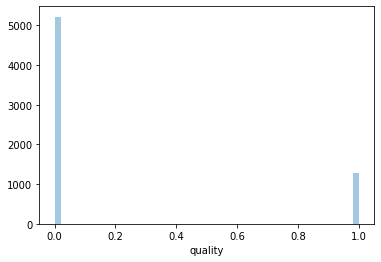

In [21]:
import seaborn as sns
sns.distplot(data.quality, kde=False)

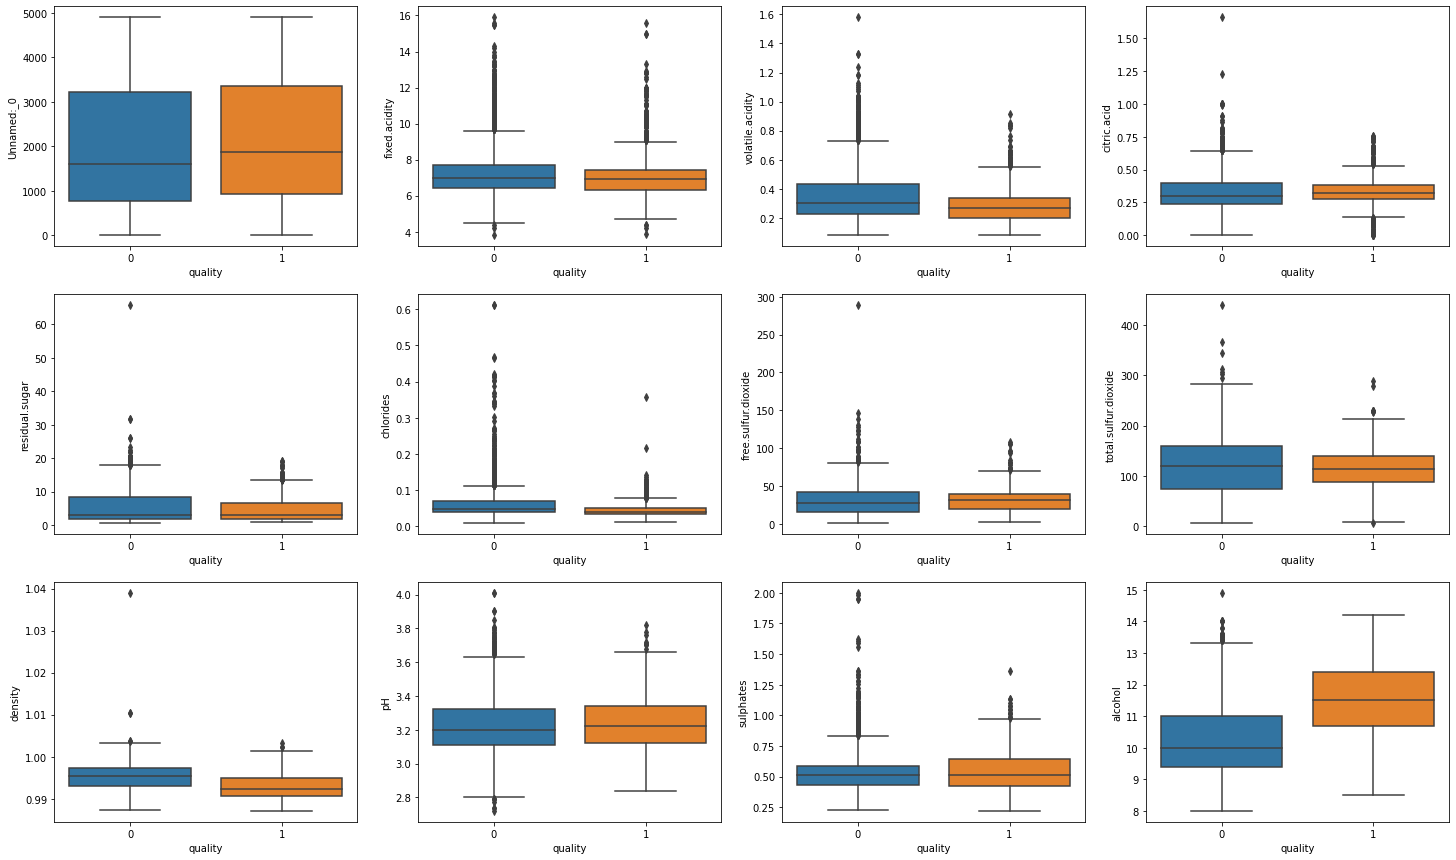

In [22]:
import matplotlib.pyplot as plt
 
dims = (3, 4)
 
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In [12]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

In [13]:
from sklearn.model_selection import train_test_split
 
X = data.drop(["quality"], axis=1)
y = data.quality
 
# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)
 
# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

In [16]:
from datetime import datetime

myprefix='Ahmet'

now = datetime.now()
date_time_str = now.strftime("%m-%d-%Y")

client = mlflow.tracking.MlflowClient()
experiment_name = date_time_str+'-'+'DEMO'
model_name = 'DEMO'
if myprefix!='':
    experiment_name = myprefix + '-' + experiment_name
    
experiment = client.get_experiment_by_name(name=experiment_name)
if(experiment is None):
    print('Creating experiment ')
    client.create_experiment(name=experiment_name)
    experiment = client.get_experiment_by_name(name=experiment_name)

print(experiment_name)
mlflow.set_experiment(experiment_name=experiment_name)

Creating experiment 
Ahmet-09-09-2022-DEMO


<Experiment: artifact_location='/artifacts/mlflow/ahmet', experiment_id='68', lifecycle_stage='active', name='Ahmet-09-09-2022-DEMO', tags={'domino.project': 'MLflow-Demo-Git',
 'mlflow.domino.project': 'MLflow-Demo-Git',
 'mlflow.domino.project_id': '62d01656a15df51728c4b86c',
 'mlflow.domino.project_identity': 'MLflow-Demo-Git',
 'mlflow.domino.user': 'ahmet',
 'mlflow.user': 'ahmet'}>

In [17]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time
 
# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 
 
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]
 
# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)
 
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/opt/conda/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [18]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.162859
density,0.102936
Unnamed:_0,0.095837
volatile.acidity,0.083580
free.sulfur.dioxide,0.075871
sulphates,0.072851
fixed.acidity,0.069760
chlorides,0.069573
pH,0.068571
residual.sugar,0.068285


In [23]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [24]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'wine_quality' already exists. Creating a new version of this model...
2022/09/09 00:55:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: wine_quality, version 1
Created version '1' of model 'wine_quality'.


In [25]:
from mlflow.tracking import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

MlflowException: API request to endpoint /api/2.0/preview/mlflow/model-versions/transition-stage failed with error code 401 != 200. Response body: 'Transitioning model versions is unauthorized'

In [27]:
!pip install hyperopt

     |████████████████████████████████| 1.6 MB 34.8 MB/s eta 0:00:01
     |████████████████████████████████| 200 kB 122.3 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 96.4 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=5e98353ba6993194bc9899417c42cf46f2c1a4d5444ccd82a90576b6c62fccee
  Stored in directory: /home/ubuntu/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future


In [ ]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb
 
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}
 
def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_val, label=y_val)
    # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)
    validation_predictions = booster.predict(validation)
    auc_score = roc_auc_score(y_val, validation_predictions)
    mlflow.log_metric('auc', auc_score)
 
    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}
 
# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
#spark_trials = SparkTrials(parallelism=10)
 
# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=96,
    #trials=spark_trials,
  )

[00:58:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.59783                        
[1]	validation-logloss:0.53496                        
[2]	validation-logloss:0.48946                        
[3]	validation-logloss:0.45436                        
[4]	validation-logloss:0.42782                        
[5]	validation-logloss:0.40812                        
[6]	validation-logloss:0.39237                        
[7]	validation-logloss:0.38007                        
[8]	validation-logloss:0.36923                        
[9]	validation-logloss:0.36015                        
[10]	validation-logloss:0.35460                       
[11]	validation-logloss:0.35019                       
[12]	validation-logloss:0.34525                       
[13]	validation-logloss:0.34124  

2022/09/09 00:59:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Pyt

[00:59:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.53704                                                     
[1]	validation-logloss:0.45839                                                     
[2]	validation-logloss:0.40416                                                     
[3]	validation-logloss:0.37591                                                     
[4]	validation-logloss:0.35488                                                     
[5]	validation-logloss:0.34463                                                     
[6]	validation-logloss:0.33488                                                     
[7]	validation-logloss:0.32946                                                     
[8]	validation-logloss:0.32856                                              

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[00:59:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.65152                                                    
[1]	validation-logloss:0.61387                                                    
[2]	validation-logloss:0.58362                                                    
[3]	validation-logloss:0.55521                                                    
[4]	validation-logloss:0.53093                                                    
[5]	validation-logloss:0.50992                                                    
[6]	validation-logloss:0.49142                                                    
[7]	validation-logloss:0.47409                                                    
[8]	validation-logloss:0.45896                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:00:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.42366                                                     
[1]	validation-logloss:0.39742                                                     
[2]	validation-logloss:0.39388                                                     
[3]	validation-logloss:0.40027                                                     
[4]	validation-logloss:0.41164                                                     
[5]	validation-logloss:0.40352                                                     
[6]	validation-logloss:0.40592                                                     
[7]	validation-logloss:0.42972                                                     
[8]	validation-logloss:0.42874                                              

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:01:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.58425                                                     
[1]	validation-logloss:0.51528                                                     
[2]	validation-logloss:0.46848                                                     
[3]	validation-logloss:0.43341                                                     
[4]	validation-logloss:0.40587                                                     
[5]	validation-logloss:0.38720                                                     
[6]	validation-logloss:0.37256                                                     
[7]	validation-logloss:0.36119                                                     
[8]	validation-logloss:0.35385                                              

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:02:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.42161                                                     
[1]	validation-logloss:0.39385                                                     
[2]	validation-logloss:0.39218                                                     
[3]	validation-logloss:0.40576                                                     
[4]	validation-logloss:0.42533                                                     
[5]	validation-logloss:0.43020                                                     
[6]	validation-logloss:0.43556                                                     
[7]	validation-logloss:0.44624                                                     
[8]	validation-logloss:0.45875                                              

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:02:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.53469                                                     
[1]	validation-logloss:0.45651                                                     
[2]	validation-logloss:0.41525                                                     
[3]	validation-logloss:0.38874                                                     
[4]	validation-logloss:0.36936                                                     
[5]	validation-logloss:0.35788                                                     
[6]	validation-logloss:0.34840                                                     
[7]	validation-logloss:0.34507                                                     
[8]	validation-logloss:0.34378                                              

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:03:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.63320                                                     
[1]	validation-logloss:0.58569                                                     
[2]	validation-logloss:0.54453                                                     
[3]	validation-logloss:0.51259                                                     
[4]	validation-logloss:0.48512                                                     
[5]	validation-logloss:0.46293                                                     
[6]	validation-logloss:0.44426                                                     
[7]	validation-logloss:0.42954                                                     
[8]	validation-logloss:0.41485                                              

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:04:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.57505                                                     
[1]	validation-logloss:0.50570                                                     
[2]	validation-logloss:0.46067                                                     
[3]	validation-logloss:0.42904                                                     
[4]	validation-logloss:0.40630                                                     
[5]	validation-logloss:0.38915                                                     
[6]	validation-logloss:0.37755                                                     
[7]	validation-logloss:0.36847                                                     
[8]	validation-logloss:0.36184                                              

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:05:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.62968                                                     
[1]	validation-logloss:0.57939                                                     
[2]	validation-logloss:0.54003                                                     
[3]	validation-logloss:0.50669                                                     
[4]	validation-logloss:0.47849                                                     
[5]	validation-logloss:0.45180                                                     
[6]	validation-logloss:0.43186                                                     
[7]	validation-logloss:0.41269                                                     
[8]	validation-logloss:0.39802                                              

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:06:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.42734                                                    
[1]	validation-logloss:0.38410                                                    
[2]	validation-logloss:0.37892                                                    
[3]	validation-logloss:0.38533                                                    
[4]	validation-logloss:0.39308                                                    
[5]	validation-logloss:0.39665                                                    
[6]	validation-logloss:0.39778                                                    
[7]	validation-logloss:0.40340                                                    
[8]	validation-logloss:0.41637                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:07:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.63517                                                    
[1]	validation-logloss:0.59014                                                    
[2]	validation-logloss:0.55281                                                    
[3]	validation-logloss:0.52131                                                    
[4]	validation-logloss:0.49580                                                    
[5]	validation-logloss:0.47427                                                    
[6]	validation-logloss:0.45667                                                    
[7]	validation-logloss:0.44109                                                    
[8]	validation-logloss:0.42827                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:09:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.53745                                                    
[1]	validation-logloss:0.46569                                                    
[2]	validation-logloss:0.42532                                                    
[3]	validation-logloss:0.40181                                                    
[4]	validation-logloss:0.39015                                                    
[5]	validation-logloss:0.38062                                                    
[6]	validation-logloss:0.37600                                                    
[7]	validation-logloss:0.36967                                                    
[8]	validation-logloss:0.36738                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:10:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.54617                                                    
[1]	validation-logloss:0.46633                                                    
[2]	validation-logloss:0.41571                                                    
[3]	validation-logloss:0.38712                                                    
[4]	validation-logloss:0.36239                                                    
[5]	validation-logloss:0.35004                                                    
[6]	validation-logloss:0.34083                                                    
[7]	validation-logloss:0.33547                                                    
[8]	validation-logloss:0.33417                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:11:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.65717                                                    
[1]	validation-logloss:0.62461                                                    
[2]	validation-logloss:0.59709                                                    
[3]	validation-logloss:0.57266                                                    
[4]	validation-logloss:0.55073                                                    
[5]	validation-logloss:0.53095                                                    
[6]	validation-logloss:0.51257                                                    
[7]	validation-logloss:0.49569                                                    
[8]	validation-logloss:0.48069                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:13:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.52628                                                    
[1]	validation-logloss:0.45571                                                    
[2]	validation-logloss:0.41395                                                    
[3]	validation-logloss:0.38959                                                    
[4]	validation-logloss:0.37109                                                    
[5]	validation-logloss:0.35877                                                    
[6]	validation-logloss:0.35068                                                    
[7]	validation-logloss:0.34492                                                    
[8]	validation-logloss:0.34161                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:14:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.58517                                                    
[1]	validation-logloss:0.51286                                                    
[2]	validation-logloss:0.46428                                                    
[3]	validation-logloss:0.43058                                                    
[4]	validation-logloss:0.40119                                                    
[5]	validation-logloss:0.37915                                                    
[6]	validation-logloss:0.36602                                                    
[7]	validation-logloss:0.35706                                                    
[8]	validation-logloss:0.35074                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:15:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.60583                                                    
[1]	validation-logloss:0.54217                                                    
[2]	validation-logloss:0.49541                                                    
[3]	validation-logloss:0.45819                                                    
[4]	validation-logloss:0.42993                                                    
[5]	validation-logloss:0.40759                                                    
[6]	validation-logloss:0.38802                                                    
[7]	validation-logloss:0.37413                                                    
[8]	validation-logloss:0.36347                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:16:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.65463                                                    
[1]	validation-logloss:0.62219                                                    
[2]	validation-logloss:0.59449                                                    
[3]	validation-logloss:0.57008                                                    
[4]	validation-logloss:0.54851                                                    
[5]	validation-logloss:0.52982                                                    
[6]	validation-logloss:0.51285                                                    
[7]	validation-logloss:0.49753                                                    
[8]	validation-logloss:0.48479                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:19:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.49387                                                    
[1]	validation-logloss:0.41979                                                    
[2]	validation-logloss:0.38614                                                    
[3]	validation-logloss:0.36727                                                    
[4]	validation-logloss:0.35959                                                    
[5]	validation-logloss:0.35558                                                    
[6]	validation-logloss:0.35143                                                    
[7]	validation-logloss:0.35215                                                    
[8]	validation-logloss:0.34934                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:19:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.66115                                                    
[1]	validation-logloss:0.63121                                                    
[2]	validation-logloss:0.60542                                                    
[3]	validation-logloss:0.58198                                                    
[4]	validation-logloss:0.56010                                                    
[5]	validation-logloss:0.54106                                                    
[6]	validation-logloss:0.52286                                                    
[7]	validation-logloss:0.50739                                                    
[8]	validation-logloss:0.49260                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:21:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.62919                                                      
[1]	validation-logloss:0.57854                                                      
[2]	validation-logloss:0.53775                                                      
[3]	validation-logloss:0.50533                                                      
[4]	validation-logloss:0.48028                                                      
[5]	validation-logloss:0.45689                                                      
[6]	validation-logloss:0.43860                                                      
[7]	validation-logloss:0.42115                                                      
[8]	validation-logloss:0.40516                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:22:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.66300                                                      
[1]	validation-logloss:0.63536                                                      
[2]	validation-logloss:0.61183                                                      
[3]	validation-logloss:0.58941                                                      
[4]	validation-logloss:0.56947                                                      
[5]	validation-logloss:0.55156                                                      
[6]	validation-logloss:0.53456                                                      
[7]	validation-logloss:0.51953                                                      
[8]	validation-logloss:0.50516                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:23:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.66329                                                      
[1]	validation-logloss:0.63668                                                      
[2]	validation-logloss:0.61261                                                      
[3]	validation-logloss:0.59097                                                      
[4]	validation-logloss:0.57066                                                      
[5]	validation-logloss:0.55299                                                      
[6]	validation-logloss:0.53662                                                      
[7]	validation-logloss:0.52159                                                      
[8]	validation-logloss:0.50724                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:25:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.61432                                                      
[1]	validation-logloss:0.55775                                                      
[2]	validation-logloss:0.51305                                                      
[3]	validation-logloss:0.47819                                                      
[4]	validation-logloss:0.44836                                                      
[5]	validation-logloss:0.42620                                                      
[6]	validation-logloss:0.40552                                                      
[7]	validation-logloss:0.38864                                                      
[8]	validation-logloss:0.37332                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:26:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.64332                                                      
[1]	validation-logloss:0.60037                                                      
[2]	validation-logloss:0.56550                                                      
[3]	validation-logloss:0.53480                                                      
[4]	validation-logloss:0.50994                                                      
[5]	validation-logloss:0.48831                                                      
[6]	validation-logloss:0.46933                                                      
[7]	validation-logloss:0.45112                                                      
[8]	validation-logloss:0.43443                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:27:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.65555                                                      
[1]	validation-logloss:0.62149                                                      
[2]	validation-logloss:0.59222                                                      
[3]	validation-logloss:0.56784                                                      
[4]	validation-logloss:0.54419                                                      
[5]	validation-logloss:0.52260                                                      
[6]	validation-logloss:0.50398                                                      
[7]	validation-logloss:0.48739                                                      
[8]	validation-logloss:0.47255                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:28:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.65449                                                      
[1]	validation-logloss:0.62095                                                      
[2]	validation-logloss:0.59074                                                      
[3]	validation-logloss:0.56490                                                      
[4]	validation-logloss:0.54190                                                      
[5]	validation-logloss:0.52206                                                      
[6]	validation-logloss:0.50436                                                      
[7]	validation-logloss:0.48874                                                      
[8]	validation-logloss:0.47391                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:30:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.66319                                                      
[1]	validation-logloss:0.63558                                                      
[2]	validation-logloss:0.61074                                                      
[3]	validation-logloss:0.58930                                                      
[4]	validation-logloss:0.56875                                                      
[5]	validation-logloss:0.55013                                                      
[6]	validation-logloss:0.53254                                                      
[7]	validation-logloss:0.51707                                                      
[8]	validation-logloss:0.50249                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:31:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.66019                                                      
[1]	validation-logloss:0.63060                                                      
[2]	validation-logloss:0.60455                                                      
[3]	validation-logloss:0.58212                                                      
[4]	validation-logloss:0.56165                                                      
[5]	validation-logloss:0.54384                                                      
[6]	validation-logloss:0.52732                                                      
[7]	validation-logloss:0.51172                                                      
[8]	validation-logloss:0.49695                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:33:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.63915                                                      
[1]	validation-logloss:0.59432                                                      
[2]	validation-logloss:0.55678                                                      
[3]	validation-logloss:0.52711                                                      
[4]	validation-logloss:0.50101                                                      
[5]	validation-logloss:0.47921                                                      
[6]	validation-logloss:0.46117                                                      
[7]	validation-logloss:0.44422                                                      
[8]	validation-logloss:0.43090                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:34:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.60823                                                      
[1]	validation-logloss:0.54772                                                      
[2]	validation-logloss:0.50461                                                      
[3]	validation-logloss:0.46930                                                      
[4]	validation-logloss:0.44109                                                      
[5]	validation-logloss:0.41109                                                      
[6]	validation-logloss:0.39093                                                      
[7]	validation-logloss:0.37577                                                      
[8]	validation-logloss:0.36378                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:35:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.46583                                                      
[1]	validation-logloss:0.40560                                                      
[2]	validation-logloss:0.37188                                                      
[3]	validation-logloss:0.35909                                                      
[4]	validation-logloss:0.35960                                                      
[5]	validation-logloss:0.35940                                                      
[6]	validation-logloss:0.35919                                                      
[7]	validation-logloss:0.37102                                                      
[8]	validation-logloss:0.37645                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:36:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.64917                                                      
[1]	validation-logloss:0.61106                                                      
[2]	validation-logloss:0.57971                                                      
[3]	validation-logloss:0.55241                                                      
[4]	validation-logloss:0.52802                                                      
[5]	validation-logloss:0.50677                                                      
[6]	validation-logloss:0.48696                                                      
[7]	validation-logloss:0.47070                                                      
[8]	validation-logloss:0.45546                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:37:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.65777                                                      
[1]	validation-logloss:0.62552                                                      
[2]	validation-logloss:0.59735                                                      
[3]	validation-logloss:0.57194                                                      
[4]	validation-logloss:0.55021                                                      
[5]	validation-logloss:0.52988                                                      
[6]	validation-logloss:0.51102                                                      
[7]	validation-logloss:0.49517                                                      
[8]	validation-logloss:0.48131                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:38:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.60074                                                      
[1]	validation-logloss:0.53643                                                      
[2]	validation-logloss:0.48828                                                      
[3]	validation-logloss:0.45385                                                      
[4]	validation-logloss:0.42681                                                      
[5]	validation-logloss:0.40398                                                      
[6]	validation-logloss:0.38768                                                      
[7]	validation-logloss:0.37295                                                      
[8]	validation-logloss:0.36063                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:39:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.57759                                                      
[1]	validation-logloss:0.50317                                                      
[2]	validation-logloss:0.45288                                                      
[3]	validation-logloss:0.41702                                                      
[4]	validation-logloss:0.39128                                                      
[5]	validation-logloss:0.37010                                                      
[6]	validation-logloss:0.35863                                                      
[7]	validation-logloss:0.34337                                                      
[8]	validation-logloss:0.33496                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:40:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.61669                                                    
[1]	validation-logloss:0.55901                                                    
[2]	validation-logloss:0.51466                                                    
[3]	validation-logloss:0.48003                                                    
[4]	validation-logloss:0.45277                                                    
[5]	validation-logloss:0.42924                                                    
[6]	validation-logloss:0.40843                                                    
[7]	validation-logloss:0.39074                                                    
[8]	validation-logloss:0.37580                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:41:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.63681                                                    
[1]	validation-logloss:0.59093                                                    
[2]	validation-logloss:0.55338                                                    
[3]	validation-logloss:0.52249                                                    
[4]	validation-logloss:0.49678                                                    
[5]	validation-logloss:0.47611                                                    
[6]	validation-logloss:0.45611                                                    
[7]	validation-logloss:0.43927                                                    
[8]	validation-logloss:0.42311                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:42:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.64910                                                    
[1]	validation-logloss:0.60982                                                    
[2]	validation-logloss:0.57665                                                    
[3]	validation-logloss:0.54804                                                    
[4]	validation-logloss:0.52152                                                    
[5]	validation-logloss:0.49851                                                    
[6]	validation-logloss:0.47911                                                    
[7]	validation-logloss:0.46182                                                    
[8]	validation-logloss:0.44665                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:43:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.66091                                                    
[1]	validation-logloss:0.63167                                                    
[2]	validation-logloss:0.60684                                                    
[3]	validation-logloss:0.58354                                                    
[4]	validation-logloss:0.56311                                                    
[5]	validation-logloss:0.54514                                                    
[6]	validation-logloss:0.52872                                                    
[7]	validation-logloss:0.51306                                                    
[8]	validation-logloss:0.49894                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:44:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.65332                                                      
[1]	validation-logloss:0.61802                                                      
[2]	validation-logloss:0.58899                                                      
[3]	validation-logloss:0.56237                                                      
[4]	validation-logloss:0.53873                                                      
[5]	validation-logloss:0.51827                                                      
[6]	validation-logloss:0.49934                                                      
[7]	validation-logloss:0.48278                                                      
[8]	validation-logloss:0.46830                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:46:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.62572                                                      
[1]	validation-logloss:0.57388                                                      
[2]	validation-logloss:0.53092                                                      
[3]	validation-logloss:0.49826                                                      
[4]	validation-logloss:0.47187                                                      
[5]	validation-logloss:0.44878                                                      
[6]	validation-logloss:0.43052                                                      
[7]	validation-logloss:0.41454                                                      
[8]	validation-logloss:0.40007                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:47:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.44556                                                      
[1]	validation-logloss:0.39422                                                      
[2]	validation-logloss:0.37029                                                      
[3]	validation-logloss:0.36164                                                      
[4]	validation-logloss:0.36490                                                      
[5]	validation-logloss:0.36569                                                      
[6]	validation-logloss:0.37480                                                      
[7]	validation-logloss:0.38046                                                      
[8]	validation-logloss:0.38158                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:47:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.55188                                                    
[1]	validation-logloss:0.47178                                                    
[2]	validation-logloss:0.42117                                                    
[3]	validation-logloss:0.39181                                                    
[4]	validation-logloss:0.37022                                                    
[5]	validation-logloss:0.35507                                                    
[6]	validation-logloss:0.34397                                                    
[7]	validation-logloss:0.33752                                                    
[8]	validation-logloss:0.33166                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:48:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.49398                                                    
[1]	validation-logloss:0.42846                                                    
[2]	validation-logloss:0.40159                                                    
[3]	validation-logloss:0.38336                                                    
[4]	validation-logloss:0.37536                                                    
[5]	validation-logloss:0.37406                                                    
[6]	validation-logloss:0.37676                                                    
[7]	validation-logloss:0.38146                                                    
[8]	validation-logloss:0.38703                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:49:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.57689                                                    
[1]	validation-logloss:0.50428                                                    
[2]	validation-logloss:0.45344                                                    
[3]	validation-logloss:0.42127                                                    
[4]	validation-logloss:0.39328                                                    
[5]	validation-logloss:0.37446                                                    
[6]	validation-logloss:0.35885                                                    
[7]	validation-logloss:0.34567                                                    
[8]	validation-logloss:0.33831                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:49:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.66136                                                    
[1]	validation-logloss:0.63282                                                    
[2]	validation-logloss:0.60783                                                    
[3]	validation-logloss:0.58550                                                    
[4]	validation-logloss:0.56446                                                    
[5]	validation-logloss:0.54631                                                    
[6]	validation-logloss:0.52913                                                    
[7]	validation-logloss:0.51432                                                    
[8]	validation-logloss:0.50009                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:51:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.63990                                                    
[1]	validation-logloss:0.59566                                                    
[2]	validation-logloss:0.56055                                                    
[3]	validation-logloss:0.52940                                                    
[4]	validation-logloss:0.50347                                                    
[5]	validation-logloss:0.47989                                                    
[6]	validation-logloss:0.46061                                                    
[7]	validation-logloss:0.44422                                                    
[8]	validation-logloss:0.42897                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:52:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.65191                                                    
[1]	validation-logloss:0.61726                                                    
[2]	validation-logloss:0.58718                                                    
[3]	validation-logloss:0.56135                                                    
[4]	validation-logloss:0.53898                                                    
[5]	validation-logloss:0.51960                                                    
[6]	validation-logloss:0.50165                                                    
[7]	validation-logloss:0.48660                                                    
[8]	validation-logloss:0.47350                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:54:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.62111                                                      
[1]	validation-logloss:0.56466                                                      
[2]	validation-logloss:0.52028                                                      
[3]	validation-logloss:0.48586                                                      
[4]	validation-logloss:0.45718                                                      
[5]	validation-logloss:0.43429                                                      
[6]	validation-logloss:0.41524                                                      
[7]	validation-logloss:0.39866                                                      
[8]	validation-logloss:0.38559                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:55:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.65716                                                    
[1]	validation-logloss:0.62617                                                    
[2]	validation-logloss:0.59918                                                    
[3]	validation-logloss:0.57559                                                    
[4]	validation-logloss:0.55424                                                    
[5]	validation-logloss:0.53429                                                    
[6]	validation-logloss:0.51617                                                    
[7]	validation-logloss:0.50045                                                    
[8]	validation-logloss:0.48558                                                    
[

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:57:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.58811                                                      
[1]	validation-logloss:0.52053                                                      
[2]	validation-logloss:0.47182                                                      
[3]	validation-logloss:0.43565                                                      
[4]	validation-logloss:0.40817                                                      
[5]	validation-logloss:0.38740                                                      
[6]	validation-logloss:0.37479                                                      
[7]	validation-logloss:0.36116                                                      
[8]	validation-logloss:0.35131                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:58:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.52693                                                      
[1]	validation-logloss:0.43840                                                      
[2]	validation-logloss:0.39528                                                      
[3]	validation-logloss:0.36208                                                      
[4]	validation-logloss:0.34092                                                      
[5]	validation-logloss:0.32791                                                      
[6]	validation-logloss:0.31911                                                      
[7]	validation-logloss:0.31254                                                      
[8]	validation-logloss:0.31187                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:59:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.52599                                                      
[1]	validation-logloss:0.44138                                                      
[2]	validation-logloss:0.40018                                                      
[3]	validation-logloss:0.36394                                                      
[4]	validation-logloss:0.34530                                                      
[5]	validation-logloss:0.33394                                                      
[6]	validation-logloss:0.32863                                                      
[7]	validation-logloss:0.32434                                                      
[8]	validation-logloss:0.32106                                      

/opt/conda/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[01:59:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-logloss:0.49464                                                      
[1]	validation-logloss:0.41438                                                      
[2]	validation-logloss:0.37683                                                      
[3]	validation-logloss:0.35035                                                      
[4]	validation-logloss:0.34707                                                      
[5]	validation-logloss:0.34419                                                      
[6]	validation-logloss:0.34088                                                      
[7]	validation-logloss:0.34323                                                      
[8]	validation-logloss:0.34904                                      